# Raise your hand if you are not here:
<img src="images/raisehand2.png" style="width: 400px;"/>

### What we have for this investigation:
- a couple concepts...
- a couple graphs to visualize missing data...
- three simple imputation examples...
- testing the imputed datasets...
- categorical feature...

### Assume you have invistigated into the reasons why values are missing and have decided what to do...
### Univariate vs Multivariate imputation
From lecture, we learned two missing value handling strategies 
1. dropping rows with missing values 
2. fill missing values with mean, median, etc <br>
Strategy 2 is what we call a univariate imputation where you use the observed values from the feature to fill in the missing values. <br>
**BUT... we could also use the entire set of features in the dataset to estimate the missing values in a feature!**

### How does multivariate imputation work?
For a feature with missing values, its observed values (as the output) is regressed on the other features (as the input) in the data, and then the regressor is used to predict the missing values. This is done for each feature with missing values in an iterative fashion. The results of the final round of imputation are returned. <br>
1. Missing values are filled in randomly from observed values
2. Apply regressor to impute feature one at a time
3. Terminate iteration when the average imputed values converge

<img src="images/mice_flow_chart.png" style="width: 750px;"/>
Image comes from https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html

### Single vs. Multiple Imputations:
- If we were interested in understanding the uncertainty associated with the missing values, the dataset should be imputed multiple times and each set is used for separate analysis. 
> Imputing one value for a missing datum cannot be correct in general, because we don’t know what value to impute with certainty (if we did, it wouldn’t be missing). -- **Donald B. Rubin**
- IterativeImputer only returns the result of a single imputation (because for preditive modeling, uncertainty is less of an interest). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

%matplotlib inline

### Loading the iris dataset from sklearn:

In [2]:
iris = load_iris() 
df = pd.DataFrame(data = np.c_[iris["data"], iris["target"]],\
                     columns = iris["feature_names"] + ["species"])
# no missing value in the dataset to start with
df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Introducing missing values in sepal_length and petal_width:

In [4]:
df_miss = df.copy()

np.random.seed(11)
mask = np.random.randint(0, 150, size = 15)
mask2 = np.random.randint(0, 150, size = 10)

df_miss["sepal length (cm)"][mask] = np.nan
df_miss["petal width (cm)"][mask2] = np.nan

# 15 missing values are introduced to sepal length and 10 to petal width
df_miss.isna().sum()

sepal length (cm)    15
sepal width (cm)      0
petal length (cm)     0
petal width (cm)     10
species               0
dtype: int64

### Visualizing missing values:

In [5]:
import missingno as msno

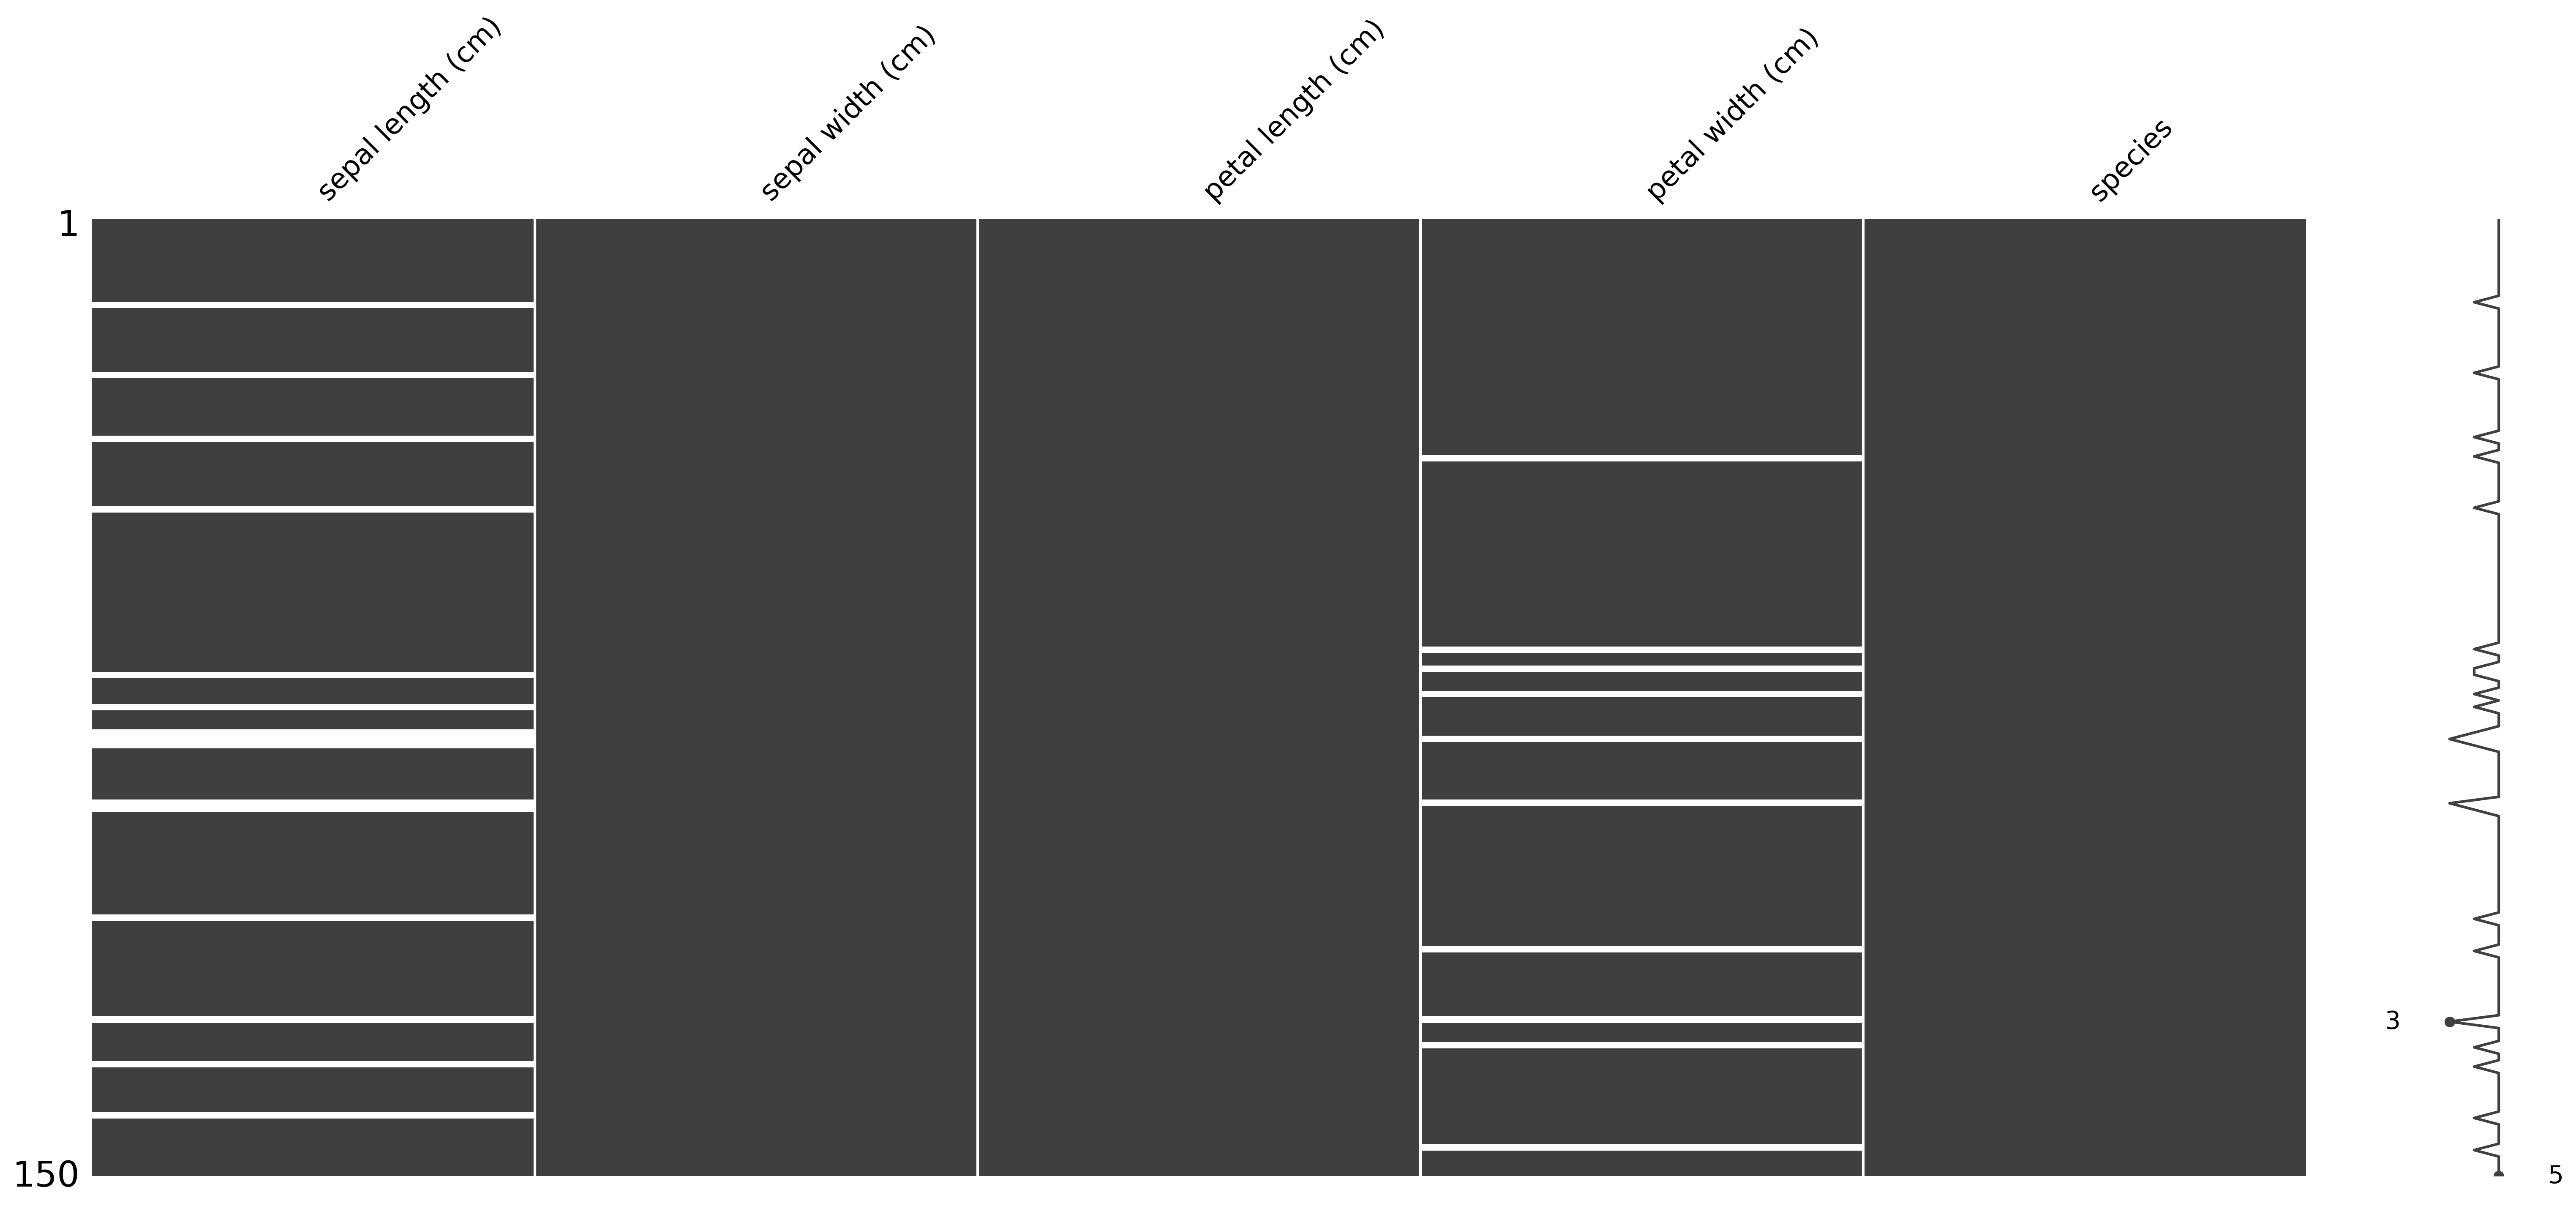

In [6]:
# there is also msno.bar(df), plotting the number of non-missing observations
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 300

msno.matrix(df_miss);
#plt.savefig("missingno_iris_matrix.png");

<Figure size 1200x1200 with 0 Axes>

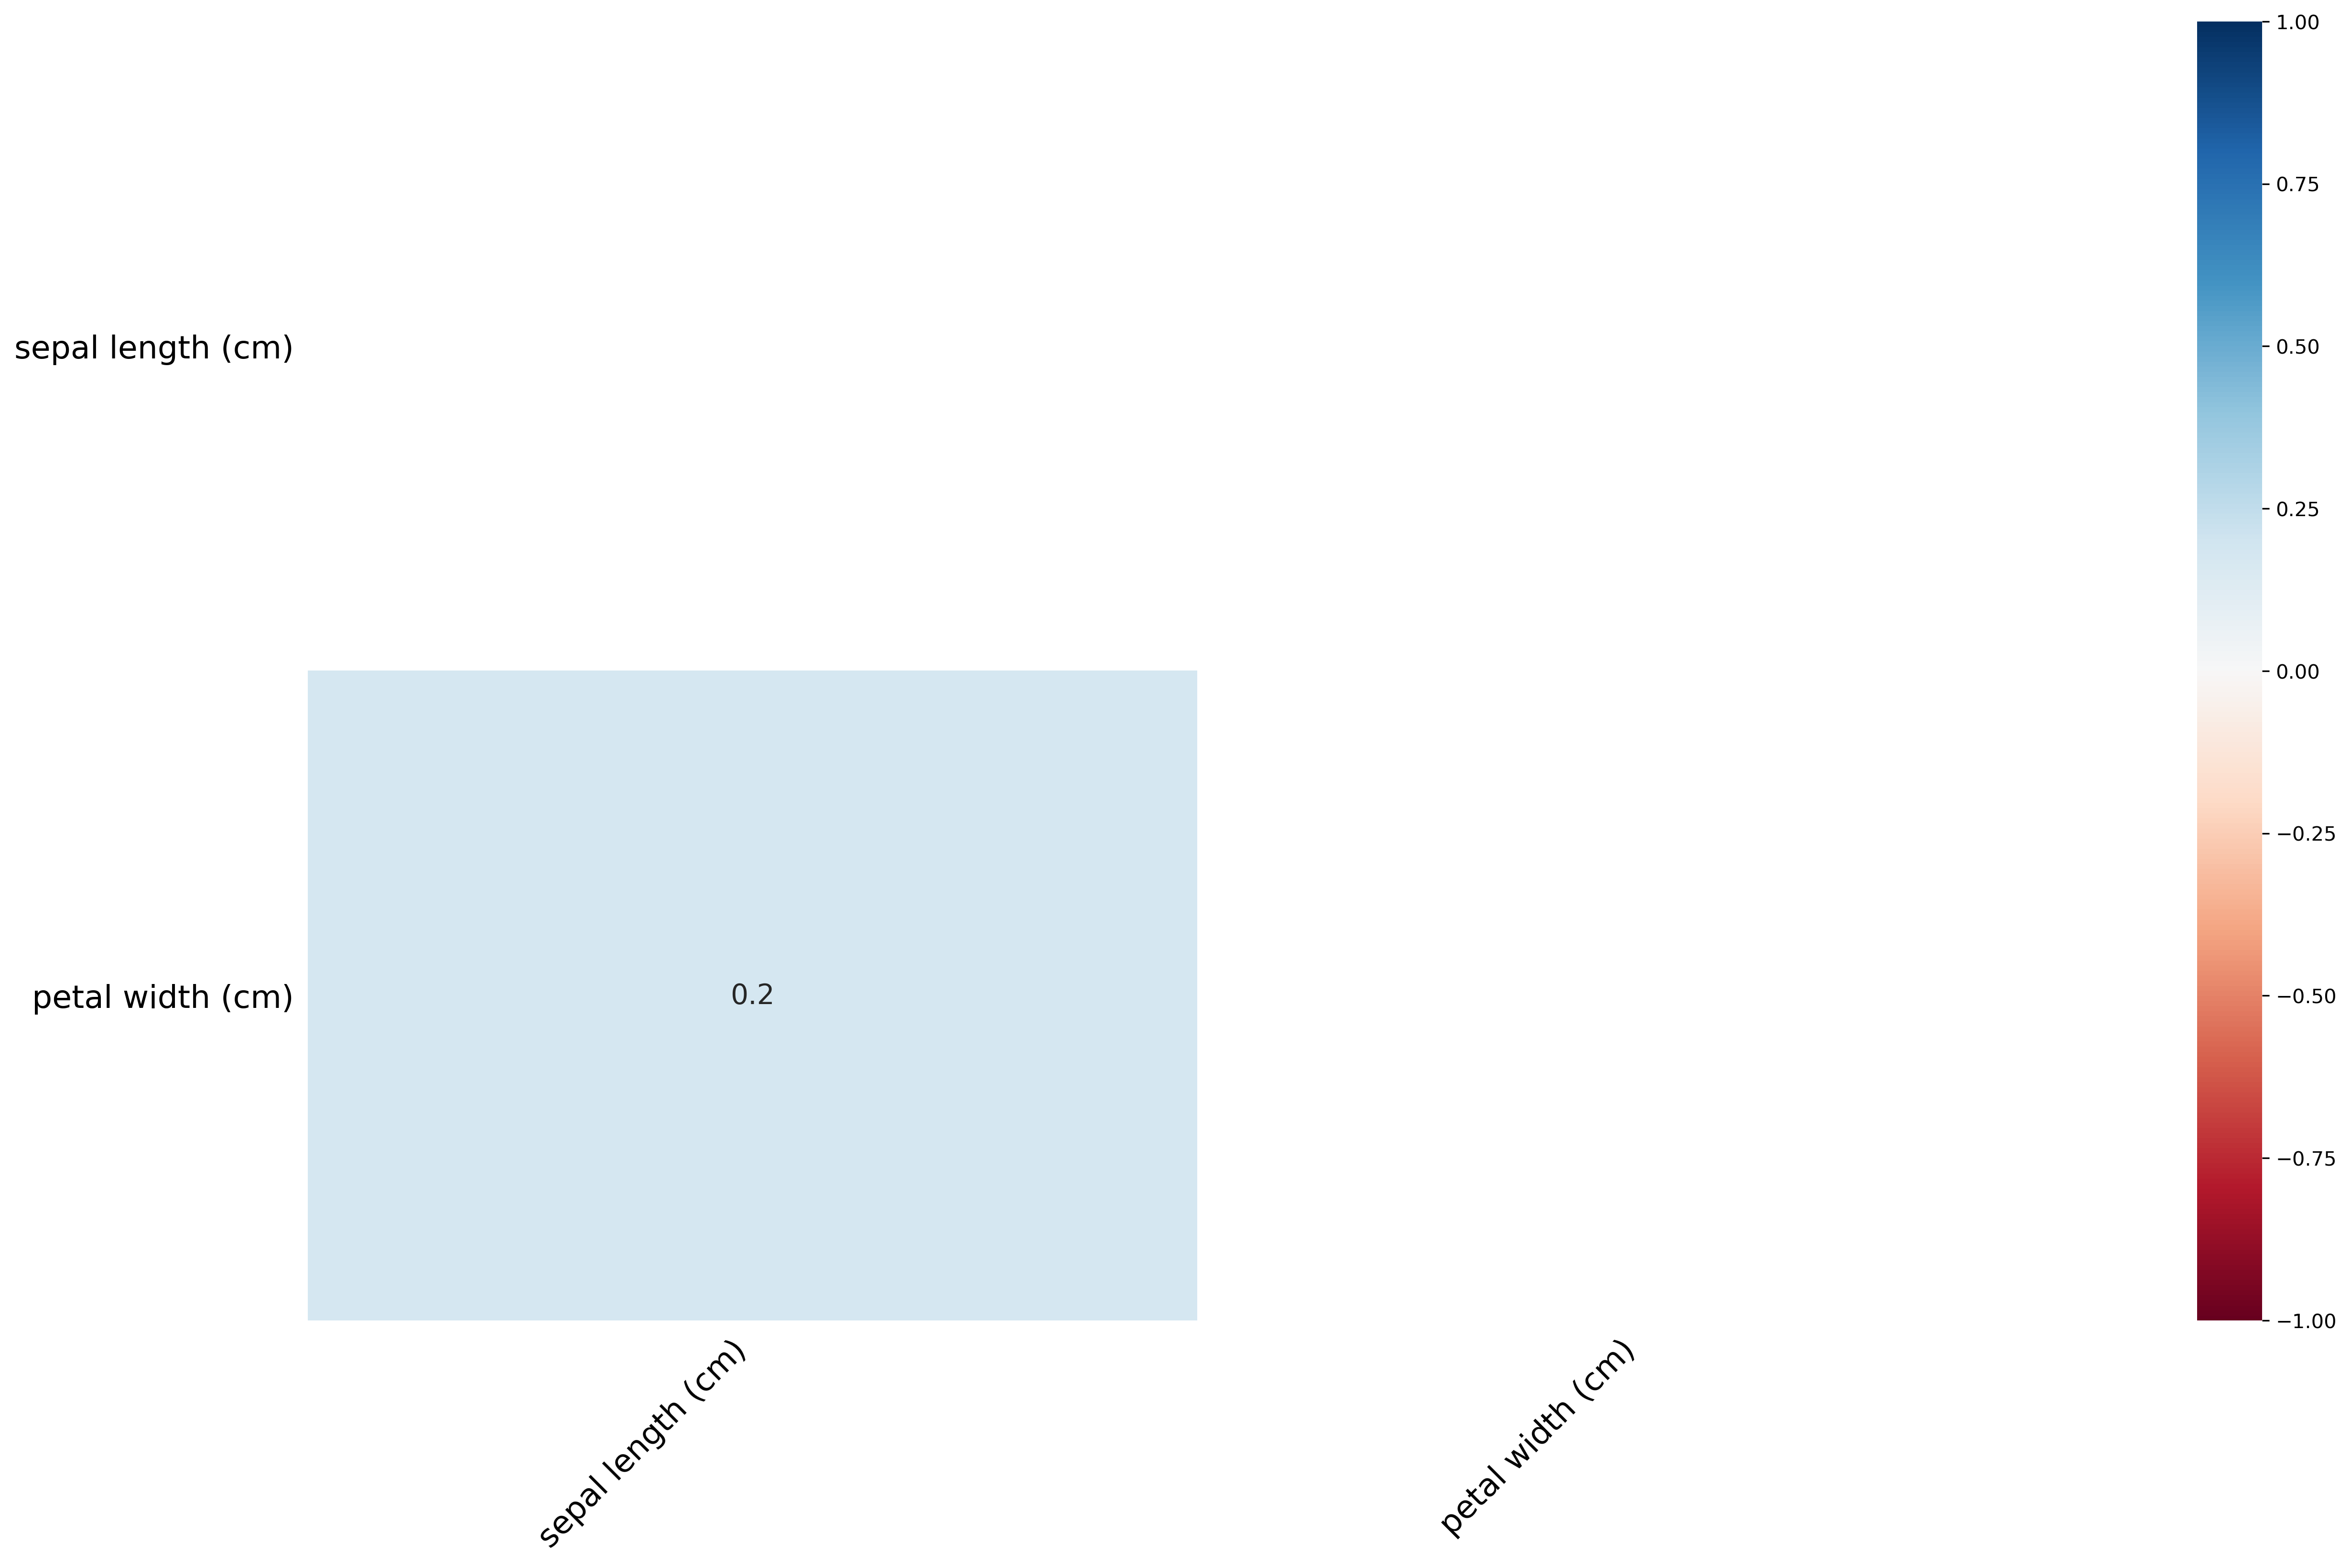

In [7]:
# this shows the correlation between missing values of the two features
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.dpi"] = 300
plt.tight_layout()
msno.heatmap(df_miss);
#plt.savefig("missingno_iris_heatmap.png");

### Imputing missing values with IterativeImputer:

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [9]:
df_ii = df_miss.copy()
# pull out only the non-target variables from the dataset
with_missing = df_ii.iloc[:, 0:4]
with_missing.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [10]:
# default estimator/regressor is Baysian Ridge
ii_imputer = IterativeImputer(max_iter=10, random_state=11)
df_ii.iloc[:, 0:4] = ii_imputer.fit_transform(with_missing)

In [11]:
# missing values are filled
df_ii.isna().sum()


sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

### Imputing missing values with other variants of IterativeImputer:

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
df_rf = df_miss.copy()
# pull out only the non-target variables from the dataset
with_missing_rf = df_rf.iloc[:, 0:4]
with_missing_rf.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf_imputer = IterativeImputer(estimator=rf, random_state=17)

df_rf.iloc[:, 0:4] = rf_imputer.fit_transform(with_missing_rf)

# missing values are filled with RandomForest regressor
df_rf.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

### Imputing missing values with KNN:

In [16]:
from sklearn.impute import KNNImputer

In [17]:
df_knn = df_miss.copy()
# pull out only the non-target variables from the dataset
with_missing_knn = df_knn.iloc[:, 0:4]
with_missing_knn.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [18]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

df_knn.iloc[:, 0:4] = knn_imputer.fit_transform(with_missing_knn)
df_knn.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

### Testing the datasets with logistic regression:

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [20]:
# mask = (df_miss["sepal length (cm)"].isna()) | (df_miss["petal width (cm)"].isna())
# df_miss[mask]
df_miss = df_miss.dropna()
datasets = [df, df_miss, df_ii, df_rf, df_knn]
dfnames = ["original", "drop missing", "BayesianRidge imputed", "RandomForest imputed", "knn imputed"]

In [21]:
logit = LogisticRegression(C = 0.9, max_iter=200)
for i in range(len(datasets)):
    X_train, X_test, y_train, y_test = train_test_split(datasets[i].iloc[:, 0:4], datasets[i]["species"], \
                                                        test_size=0.3, random_state=11)
    logit.fit(X_train, y_train)
    print(f"Scores for the {dfnames[i]} dataset are")
    print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
    print("Test: {:6.2f}%".format(100*logit.score(X_test, y_test)))

Scores for the original dataset are
Training:  98.10%
Test:  93.33%
Scores for the drop missing dataset are
Training:  96.63%
Test:  97.44%
Scores for the BayesianRidge imputed dataset are
Training:  98.10%
Test:  93.33%
Scores for the RandomForest imputed dataset are
Training:  98.10%
Test:  93.33%
Scores for the knn imputed dataset are
Training:  98.10%
Test:  93.33%


### Extra steps to impute categorical feature (with strings as values):

In [ ]:
#converting categorical values (strings) to numeric either with OrdinalEncoder or one_hot_encoder
from sklearn.preprocessing import OrdinalEncoder
feature_OE = OrdinalEncoder( )

#pull out the feature to be imputed
feature_impute = df["target_feature"]

#get all the observed categories of the feature
feture_impute_observed = feature_impute[feature_impute.notnull( )] 
  
#reshape feature_impute_notnull to a 2D array
reshape_vals = var_impute_notnull.values.reshape(-1, 1)

#convert levels of the categorical feature to numbers
encoded_vals = feature_OE.fit_transform(reshape_vals)

#put the transformed values back to the dataset
data.loc[feature_impute.notnull( ), "target_feature"] = np.squeeze(encoded_vals)

In [ ]:
#imputation, and round imputed values to integers since categories are represented by integers
ii_imputer = IterativeImputer(max_iter=10, random_state=11)
df.iloc[:, :] = np.round(ii_imputer.fit_transform(df))

In [ ]:
#reverse the transformation
levels = df["target_feature"].values.reshape(-1, 1)
df["target_feature"] = feature_OE.inverse_transform(levels)

### Questions? <br> More specifics of the functions used in the demo can be found from sklearn:
<img src="images/friends_minion.png" style="width: 300px;"/>

### References:
1. https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation
2. https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer
3. https://learn.datacamp.com/courses/dealing-with-missing-data-in-python
4. https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html